# Imports and Constants: 

In [38]:
import numpy as np
import GEOMODEL as GEOMODEL
import matplotlib.pyplot as plt
import Noise as BSNoise
import gwinc  # Import the gwinc package for LIGO noise curve
c=3e8
L=1200
fsr = c/(2*L)
src = 1.109+L
fsr_src = c/(src)
frequencies = np.logspace(0,5,100000)
data = np.load('GEO_F_norm_100000_05.npz')
data2 = np.load('GEO_F_rms_100000_05.npz')

# Simulation Code: 

In [40]:
def compute_tF(p='', prm_phi='', srm_phi='', srm_T='', sq_db='', sq_angle='', sq_freq=''):
    # Create new adjusted model
    new_model = GEOMODEL.adjust_model(p=p, prm_phi=prm_phi, srm_phi=srm_phi, srm_T=srm_T, sq_db=sq_db, sq_angle=sq_angle, sq_freq=sq_freq)
    
    # Create Simulation that injects a gravitational wave over a range of frequencies of new model
    new_sim = new_model.deepcopy()
    new_sim.parse(
        f"""
        dof strain sy.dofs.h -1 sy2.dofs.h -1 sx.dofs.h +1 sx2.dofs.h +1
        readout_dc trans_sb optical_node=FI.p3.o
        frequency_response(logspace(0,5,100000), [strain.AC.i], [trans_sb.DC.o])
        """)
    
    # Run the new Simulation
    new_sim_run = new_sim.run()
    transferFunction = np.abs(new_sim_run['trans_sb.DC.o','strain.AC.i']) /data['Fp_norm']*data2['F_rms']
    # Return abs value of array of new data
    return transferFunction

In [3]:
def compute_ztF(p='', prm_phi='', srm_phi='', srm_T='', sq_db='', sq_angle='', sq_freq=''):
    
    # Create new adjusted model
    new_model2 = GEOMODEL.adjust_model(p=p, prm_phi=prm_phi, srm_phi=srm_phi, srm_T=srm_T, sq_db=sq_db, sq_angle=sq_angle, sq_freq=sq_freq)
    
    # Create Simulation that injects a gravitational wave over a range of frequencies of new model
    newer_sim = new_model2.deepcopy()
    newer_sim.parse(
        f"""
        readout_dc trans_sb2 optical_node=FI.p3.o
        frequency_response(logspace(0,5,100000), [my.mech.z, bsy.mech.z, mx.mech.z, bsx.mech.z, BS.mech.z], [trans_sb2.DC.o])
        """)
    
    # Run the new Simulation
    newer_sim_run = newer_sim.run()
    
    # Return abs value of array of new data
    return np.abs(newer_sim_run['trans_sb2.DC.o','BS.mech.z']/np.sqrt(2)), np.abs(newer_sim_run['trans_sb2.DC.o','my.mech.z']), np.abs(newer_sim_run['trans_sb2.DC.o','bsy.mech.z']), np.abs(newer_sim_run['trans_sb2.DC.o','mx.mech.z']), np.abs(newer_sim_run['trans_sb2.DC.o','bsx.mech.z'])

In [29]:
def noise_curve(p='', prm_phi='', srm_phi='', srm_T='', sq_db='', sq_angle='', sq_freq=''):
    
    # *** This simulation always sets squeezing angle to be the angle that produces a sensitivity curve with the lowest ASD value ***
    # *** Thus, this function will override/ignore any inputted squeezing parameter value if you try to set constant squeezing angle- need to call noise_curve_setSQangle() simulation for that ***
    
    # Create new adjusted model
    newModel3 = GEOMODEL.adjust_model(p=p, prm_phi=prm_phi, srm_phi=srm_phi, srm_T=srm_T, sq_db=sq_db, sq_angle=sq_angle, sq_freq=sq_freq)
    
    # Create Simulation that injects a gravitational wave over a range of frequencies of new model
    
    new_sim_noise = newModel3.deepcopy()
    new_sim_noise.parse(
        f"""
        sgen strain1 sy.h -1
        sgen strain2 sy2.h -1
        sgen strain3 sx.h +1
        sgen strain4 sx2.h +1
        
        # Create noise detectors
        qnoised quantum_nsr FI.p3.o nsr=true
        """)
    
    #Run simulation to get frequency dependent squeezing
    sol_opt_sqz = new_sim_noise.run("xaxis(fsig, log, 1, 1e5, 999, pre_step=minimize(quantum_nsr, sq1.angle))")

    # Get list of squeezing angles calcualed from simulation
    opt_angle = sol_opt_sqz["pre_step", "minimize"].x

    # Get index of lowest possible asd value from simulation
    i = np.argmin(abs(sol_opt_sqz['quantum_nsr']))

    # Set optimal squeezing angle to be the squeezing angle at the index of the lowest possible asd value
    hf_angle = opt_angle[i][0]
    #print(hf_angle%180)
    
    #Assign model to have that squeezing angle and run quantum noise simulation again, but now it is frequency independent and catered for that frequency
    new_sim_noise.sq1.angle = hf_angle
    new_sim_noise.parse(
        f"""
        # Create noise detectors
        qnoised Quantum_noise FI.p3.o nsr=false
        
        # Sweep across frequencies
        xaxis(fsig.f, log, 1, 1e5, 99999)
        """)
    
    
    # Create Simulation that modulates the amplitude of the laser
    second_sim_noise = newModel3.deepcopy()
    second_sim_noise.parse(
        f"""
        dof ampNoise laser.dofs.amp +1
        readout_dc trans_sb optical_node=FI.p3.o
        frequency_response(logspace(0,5,100000), [ampNoise.AC.i], [trans_sb.DC.o])
        """)
    
    # Create Simulation that modulates the phase of the laser
    third_sim_noise = newModel3.deepcopy()
    third_sim_noise.parse(
        f"""
        dof freqNoise laser.dofs.frq +1
        readout_dc trans_sb optical_node=FI.p3.o
        frequency_response(logspace(0,5,100000), [freqNoise.AC.i], [trans_sb.DC.o])
        """)
    
    # Run new simulation
    new_sim_noise_run = new_sim_noise.run()
    second_sim_noise_run = second_sim_noise.run()
    third_sim_noise_run = third_sim_noise.run()
    
    # Calculate total quantum noise
    quantum_noise = np.abs(new_sim_noise_run['Quantum_noise'])
    
    # Calculate other noises (laser amplitude, laser frequency, and possibly dark noise)
    laserAmp_noise = (1.5*(10**-7))*(1/frequencies)*np.abs(second_sim_noise_run['trans_sb.DC.o','ampNoise.AC.i'])
    laserFreq_noise = np.sqrt((2*(3e8)*(6.626e-34))/(newModel3.laser.P*(1064e-9)))*np.pi*frequencies*np.abs(third_sim_noise_run['trans_sb.DC.o','freqNoise.AC.i'])
    
    # Calculate total noise curve
    total_noise = np.sqrt(quantum_noise**2 + laserAmp_noise**2 + laserFreq_noise**2)
    
    # If you want to view the component tree of the model, uncomment below:
    #print(new_sim_noise.component_tree())
    
    # Return abs value of array of individual noise curves and total noise curve
    return total_noise, quantum_noise, laserAmp_noise, laserFreq_noise

In [5]:
def noise_curve_setSQangle(p='', prm_phi='', srm_phi='', srm_T='', sq_db='', sq_angle='', sq_freq=''):
    
    # Create new adjusted model
    newModel3 = GEOMODEL.adjust_model(p=p, prm_phi=prm_phi, srm_phi=srm_phi, srm_T=srm_T, sq_db=sq_db, sq_angle=sq_angle, sq_freq=sq_freq)
    
    # Create Simulation that injects a gravitational wave over a range of frequencies of new model
    
    new_sim_noise = newModel3.deepcopy()
    new_sim_noise.parse(
        f"""
        sgen strain1 sy.h -1
        sgen strain2 sy2.h -1
        sgen strain3 sx.h +1
        sgen strain4 sx2.h +1
        
        # Create noise detectors
        qnoised Quantum_noise FI.p3.o nsr=false
        #qshot qshot_noise FI.p3.o nsr=false included in Quantum_noise
        
        # Sweep across frequencies
        xaxis(fsig.f, log, 1, 1e5, 99999)
        """)
    
    # Create Simulation that modulates the amplitude of the laser
    second_sim_noise = newModel3.deepcopy()
    second_sim_noise.parse(
        f"""
        dof ampNoise laser.dofs.amp +1
        readout_dc trans_sb optical_node=FI.p3.o
        frequency_response(logspace(0,5,100000), [ampNoise.AC.i], [trans_sb.DC.o])
        """)
    
    # Create Simulation that modulates the phase of the laser
    third_sim_noise = newModel3.deepcopy()
    third_sim_noise.parse(
        f"""
        dof freqNoise laser.dofs.frq +1
        readout_dc trans_sb optical_node=FI.p3.o
        frequency_response(logspace(0,5,100000), [freqNoise.AC.i], [trans_sb.DC.o])
        """)
    
    # Run new simulation
    new_sim_noise_run = new_sim_noise.run()
    second_sim_noise_run = second_sim_noise.run()
    third_sim_noise_run = third_sim_noise.run()
    
    # Calculate total quantum noise
    quantum_noise = np.abs(new_sim_noise_run['Quantum_noise'])
    
    # Calculate other noises (laser amplitude, laser frequency, and possibly dark noise)
    laserAmp_noise = (1.5*(10**-7))*(1/frequencies)*np.abs(second_sim_noise_run['trans_sb.DC.o','ampNoise.AC.i'])
    laserFreq_noise = np.sqrt((2*(3e8)*(6.626e-34))/(newModel3.laser.P*(1064e-9)))*np.pi*frequencies*np.abs(third_sim_noise_run['trans_sb.DC.o','freqNoise.AC.i'])
    #dark_noise = (1.46e-12)*(frequencies/frequencies)
    
    # Calculate total noise curve
    total_noise = np.sqrt(quantum_noise**2 + laserAmp_noise**2 + laserFreq_noise**2)
    
    # If you want to view the component tree of the model, uncomment below:
    #print(new_sim_noise.component_tree())
    
    # Return abs value of array of individual noise curves and total noise curve
    return total_noise, quantum_noise, laserAmp_noise, laserFreq_noise

In [6]:
def NSR(transfer_Function='', beamsplitter_tF='', my_tF='', bsy_tF='', mx_tF='', bsx_tF='', quantum_noise='', laserAmp_noise='', laserFreq_noise=''):
    
    # Create Noise to Signal Ratio (NSR) array from input transfer function and noise curve
    quantum_nsr = quantum_noise/transfer_Function
    laserAmp_nsr = laserAmp_noise/transfer_Function
    laserFreq_nsr = laserFreq_noise/transfer_Function
    
   # Frequency range
    
    # Create Noise to Signal Ratio (NSR) array for displacement noises taken from analytical functions found in literature
    seismic_noise1 = (((10**-7) * (1/(frequencies**2)))*(((0.5**2)/(frequencies**2))**3)) * (my_tF/transfer_Function)
    seismic_noise2 = (((10**-7) * (1/(frequencies**2)))*(((0.5**2)/(frequencies**2))**3)) * (bsy_tF/transfer_Function)
    seismic_noise3 = (((10**-7) * (1/(frequencies**2)))*(((0.5**2)/(frequencies**2))**3)) * (mx_tF/transfer_Function)
    seismic_noise4 = (((10**-7) * (1/(frequencies**2)))*(((0.5**2)/(frequencies**2))**3)) * (bsx_tF/transfer_Function)
    seismic_noise = np.sqrt(seismic_noise1**2 + seismic_noise2**2 + seismic_noise3**2 + seismic_noise4**2)
    
    TM_coating_BM_noise1 = BSNoise.TMcoatingBM()*(my_tF/transfer_Function)*np.sqrt(2/3)
    TM_coating_BM_noise2 = BSNoise.TMcoatingBM()*(bsy_tF/transfer_Function)
    TM_coating_BM_noise3 = BSNoise.TMcoatingBM()*(mx_tF/transfer_Function)*np.sqrt(2/3)
    TM_coating_BM_noise4 = BSNoise.TMcoatingBM()*(bsx_tF/transfer_Function)
    TM_coating_BM_noise = np.sqrt(TM_coating_BM_noise1**2 + TM_coating_BM_noise2**2 + TM_coating_BM_noise3**2 + TM_coating_BM_noise4**2)
    
    TM_coating_TE_noise1 = BSNoise.TMcoatingTE()*(my_tF/transfer_Function)*np.sqrt(2/3)
    TM_coating_TE_noise2 = BSNoise.TMcoatingTE()*(bsy_tF/transfer_Function)
    TM_coating_TE_noise3 = BSNoise.TMcoatingTE()*(mx_tF/transfer_Function)*np.sqrt(2/3)
    TM_coating_TE_noise4 = BSNoise.TMcoatingTE()*(bsx_tF/transfer_Function)
    TM_coating_TE_noise = np.sqrt(TM_coating_TE_noise1**2 + TM_coating_TE_noise2**2 + TM_coating_TE_noise3**2 + TM_coating_TE_noise4**2)
    
    TM_substrate_BM_noise1 = BSNoise.TMsubstrateBM()*(my_tF/transfer_Function)
    TM_substrate_BM_noise2 = BSNoise.TMsubstrateBM()*(bsy_tF/transfer_Function)
    TM_substrate_BM_noise3 = BSNoise.TMsubstrateBM()*(mx_tF/transfer_Function)
    TM_substrate_BM_noise4 = BSNoise.TMsubstrateBM()*(bsx_tF/transfer_Function)
    TM_substrate_BM_noise = np.sqrt(TM_substrate_BM_noise1**2 + TM_substrate_BM_noise2**2 + TM_substrate_BM_noise3**2 + TM_substrate_BM_noise4**2)
    
    TM_substrate_TE_noise1  = BSNoise.ETMsubstrateTE()*(my_tF/transfer_Function) #different function for nonfolded end mirrors since it is not just a factor of sqrt(2/3) difference
    TM_substrate_TE_noise2  = BSNoise.TMsubstrateTE()*(bsy_tF/transfer_Function)
    TM_substrate_TE_noise3  = BSNoise.ETMsubstrateTE()*(mx_tF/transfer_Function)
    TM_substrate_TE_noise4  = BSNoise.TMsubstrateTE()*(bsx_tF/transfer_Function)
    TM_substrate_TE_noise = np.sqrt(TM_substrate_TE_noise1**2 + TM_substrate_TE_noise2**2 + TM_substrate_TE_noise3**2 + TM_substrate_TE_noise4**2)
    
    TM_pend_VM_noise1 = BSNoise.violinModeTE()*(my_tF/transfer_Function)
    TM_pend_VM_noise2 = BSNoise.violinModeTE()*(bsy_tF/transfer_Function)
    TM_pend_VM_noise3 = BSNoise.violinModeTE()*(mx_tF/transfer_Function)
    TM_pend_VM_noise4 = BSNoise.violinModeTE()*(bsx_tF/transfer_Function)
    TM_pend_VM_noise = np.sqrt(TM_pend_VM_noise1**2 + TM_pend_VM_noise2**2 + TM_pend_VM_noise3**2 + TM_pend_VM_noise4**2)
    
    TM_pend_PM_noise1 = BSNoise.pendulumModeTE()*(my_tF/transfer_Function)
    TM_pend_PM_noise2 = BSNoise.pendulumModeTE()*(bsy_tF/transfer_Function)
    TM_pend_PM_noise3 = BSNoise.pendulumModeTE()*(mx_tF/transfer_Function)
    TM_pend_PM_noise4 = BSNoise.pendulumModeTE()*(bsx_tF/transfer_Function)
    TM_pend_PM_noise = np.sqrt(TM_pend_PM_noise1**2 + TM_pend_PM_noise2**2 + TM_pend_PM_noise3**2 + TM_pend_PM_noise4**2)
    
    TM_suspension_noise = np.sqrt(TM_pend_VM_noise**2 + TM_pend_PM_noise**2)
    
    BS_substrate_BM_noise = BSNoise.BSsubstrateBM() * (beamsplitter_tF/transfer_Function)
    
    BS_coating_BM_noise = BSNoise.BScoatingBM() * (beamsplitter_tF/transfer_Function)
    
    BS_substrate_TR_noise = BSNoise.BSthermorefractive() * (beamsplitter_tF/transfer_Function)
    
    total_NSR = np.sqrt(quantum_nsr**2 + seismic_noise**2 + TM_coating_BM_noise**2 + TM_coating_TE_noise**2 + TM_substrate_BM_noise**2 + TM_substrate_TE_noise**2 + TM_suspension_noise**2 + BS_substrate_BM_noise**2 + BS_coating_BM_noise**2 + BS_substrate_TR_noise**2 + laserAmp_nsr**2 + laserFreq_nsr**2)
    
    # Return NSR
    return total_NSR

In [33]:
def ligo_NSR():

    # Load the Advanced LIGO noise budget
    %matplotlib widget
    budget = gwinc.load_budget('aLIGO', freq=frequencies)

    # Run the noise budget simulation
    trace = budget.run()
    
    # Create the axes values from the plot of the noise budget simulation results
    fig = trace.plot()
    ax = fig.axes[0]
    
    # Close that plot
    plt.close(fig)

    # Access the first line in the plot (first noise source)
    first_line = ax.get_lines()[0]

    # Get the x (frequency) and y (noise values) data
    x_data = first_line.get_xdata()
    y_data = first_line.get_ydata()
    
    return y_data

In [8]:
def loopin(p=[], prm_phi=[], srm_phi=[], sq_db=[], sq_angle=[], srm_T=[], sq_freq=[]):
    
    # Function that creates a Bode Plot, noise curve, and NSR graph for a given list of input changes to a parameter
    # Changes to the laser power
    
    return_obect = None
    if p!=[]:
        i = 0
        num = len(p)
        transferFunctionList = []
        noiseCurveList = []
        NSRList = []
        labels = []
        for i in range(num):
            # Compute Transfer function for value i and append to list of transfer function arrays
            transferFunction = compute_tF(p=p[i])
            beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF = compute_ztF(p=p[i])
            transferFunctionList.append(transferFunction)
            
            # Compute Noise Curve for value i and append to list of noise curve arrays
            noiseCurve, quantum_noise, laserAmp_noise, laserFreq_noise = noise_curve(p=p[i])
            noiseCurveList.append(noiseCurve)
            
            # Create Noise to Signal Ratio from TF and Noise Curve and append to list of NSR arrays
            nSR = NSR(transferFunction, beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF, quantum_noise, laserAmp_noise, laserFreq_noise)
            NSRList.append(nSR)
            
            # Create label for graph and append to label list
            labels.append(f'{p[i]} Watts')
            
        return_obect = labels, NSRList, transferFunctionList, noiseCurveList
    
    # Changes to the power recycling mirror detuning
    elif prm_phi!=[]:
        k = 0
        num2 = len(prm_phi)
        transferFunctionList2 = []
        noiseCurveList2 = []
        NSRList2 = []
        labels2 = []
        for k in range(num2):
            # Compute Transfer function for value k and append to list of transfer function arrays
            transferFunction2 = compute_tF(prm_phi=prm_phi[k])
            beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF = compute_ztF(prm_phi=prm_phi[k])
            transferFunctionList2.append(transferFunction2)
            
            # Compute Noise Curve for value k and append to list of noise curve arrays
            noiseCurve2, quantum_noise2, laserAmp_noise2, laserFreq_noise2 = noise_curve(prm_phi=prm_phi[k])
            noiseCurveList2.append(noiseCurve2)
            
            # Create Noise to Signal Ratio from TF and Noise Curve and append to list of NSR arrays
            nSR2 = NSR(transferFunction2, beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF, quantum_noise2, laserAmp_noise2, laserFreq_noise2)
            NSRList2.append(nSR2)
            
            # Create label for graph and append to label list
            labels2.append(f'{prm_phi[k]} Degrees')

        return_obect = labels2, NSRList2, transferFunctionList2, noiseCurveList2
    
    # Changes to the signal recycling mirror detuning
    elif srm_phi!=[]:
        z = 0
        num3 = len(srm_phi)
        transferFunctionList3 = []
        noiseCurveList3 = []
        NSRList3 = []
        labels3 = []
        for z in range(num3):
            # Compute Transfer function for value z and append to list of transfer function arrays
            transferFunction3 = compute_tF(srm_phi=srm_phi[z])
            beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF = compute_ztF(srm_phi=srm_phi[z])
            transferFunctionList3.append(transferFunction3)
            
            # Compute Noise Curve for value z and append to list of noise curve arrays
            noiseCurve3, quantum_noise3, laserAmp_noise3, laserFreq_noise3 = noise_curve(srm_phi=srm_phi[z])
            noiseCurveList3.append(noiseCurve3)
            
            # Create Noise to Signal Ratio from TF and Noise Curve and append to list of NSR arrays
            nSR3 = NSR(transferFunction3, beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF, quantum_noise3, laserAmp_noise3, laserFreq_noise3)
            NSRList3.append(nSR3)
            
            # Create label for graph and append to label list
            labels3.append(f'{srm_phi[z]} Degrees')

        return_obect = labels3, NSRList3, transferFunctionList3, noiseCurveList3
    
    # Changes to the squeezing angle
    elif sq_angle!=[]:
        j = 0
        num4 = len(sq_angle)
        transferFunctionList4 = []
        noiseCurveList4 = []
        NSRList4 = []
        labels4 = []
        for j in range(num4):
            # Compute Transfer function for value j and append to list of transfer function arrays
            transferFunction4 = compute_tF(sq_angle=sq_angle[j])
            beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF = compute_ztF(sq_angle=sq_angle[j])
            transferFunctionList4.append(transferFunction4)
            
            # Compute Noise Curve for value j and append to list of noise curve arrays
            noiseCurve4, quantum_noise4, laserAmp_noise4, laserFreq_noise4 = noise_curve(sq_angle=sq_angle[j])
            noiseCurveList4.append(noiseCurve4)
            
            # Create Noise to Signal Ratio from TF and Noise Curve and append to list of NSR arrays
            nSR4 = NSR(transferFunction4, beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF, quantum_noise4, laserAmp_noise4, laserFreq_noise4)
            NSRList4.append(nSR4)
            
            # Create label for graph and append to label list
            labels4.append(f'{sq_angle[j]} Degrees')
        
        return_obect = labels4, NSRList4, transferFunctionList4, noiseCurveList4
    
    # Changes to the squeezing frequency
    elif sq_freq!=[]:
        e = 0
        num5 = len(sq_freq)
        transferFunctionList5 = []
        noiseCurveList5 = []
        NSRList5 = []
        labels5 = []
        for e in range(num5):
            # Compute Transfer function for value e and append to list of transfer function arrays
            transferFunction5 = compute_tF(sq_freq=sq_freq[e])
            beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF = compute_ztF(sq_freq=sq_freq[e])
            transferFunctionList5.append(transferFunction5)
            
            # Compute Noise Curve for value e and append to list of noise curve arrays
            noiseCurve5, quantum_noise5, laserAmp_noise5, laserFreq_noise5 = noise_curve(sq_freq=sq_freq[e])
            noiseCurveList5.append(noiseCurve5)
            
            # Create Noise to Signal Ratio from TF and Noise Curve and append to list of NSR arrays
            nSR5 = NSR(transferFunction5, beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF, quantum_noise5, laserAmp_noise5, laserFreq_noise5)
            NSRList5.append(nSR5)
            
            # Create label for graph and append to label list
            labels5.append(f'{sq_freq[e]} Hz')
        
        return_obect = labels5, NSRList5, transferFunctionList5, noiseCurveList5
    
    # Changes the signal recycling mirror transmitivity
    elif srm_T!=[]:
        l = 0
        num8 = len(srm_T)
        transferFunctionList8 = []
        noiseCurveList8 = []
        NSRList8 = []
        labels8 = []
        for l in range(num8):
            # Compute Transfer function for value l and append to list of transfer function arrays
            transferFunction8 = compute_tF(srm_T=srm_T[l])
            beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF = compute_ztF(srm_T=srm_T[l])
            transferFunctionList8.append(transferFunction8)
            
            # Compute Noise Curve for value l and append to list of noise curve arrays
            noiseCurve8, quantum_noise8, laserAmp_noise8, laserFreq_noise8 = noise_curve(srm_T=srm_T[l])
            noiseCurveList8.append(noiseCurve8)
            
            # Create Noise to Signal Ratio from TF and Noise Curve and append to list of NSR arrays
            nSR8 = NSR(transferFunction8, beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF, quantum_noise8, laserAmp_noise8, laserFreq_noise8)
            NSRList8.append(nSR8)
            
            # Create label for graph and append to label list
            labels8.append(f'T = {srm_T[l]}')
        
        return_obect = labels8, NSRList8, transferFunctionList8, noiseCurveList8
        
    # Changes the decibel noise reduction from the squeezer
    elif sq_db!=[]:
        m = 0
        num9 = len(sq_db)
        transferFunctionList9 = []
        noiseCurveList9 = []
        NSRList9 = []
        labels9 = []
        for m in range(num9):
            # Compute Transfer function for value m and append to list of transfer function arrays
            transferFunction9 = compute_tF(sq_db=sq_db[m])
            beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF = compute_ztF(sq_db=sq_db[m])
            transferFunctionList9.append(transferFunction9)
            
            # Compute Noise Curve for value m and append to list of noise curve arrays
            noiseCurve9, quantum_noise9, laserAmp_noise9, laserFreq_noise9 = noise_curve(sq_db=sq_db[m])
            noiseCurveList9.append(noiseCurve9)
            
            # Create Noise to Signal Ratio from TF and Noise Curve and append to list of NSR arrays
            nSR9 = NSR(transferFunction9, beamsplitter_tF, my_tF, bsy_tF, mx_tF, bsx_tF, quantum_noise9, laserAmp_noise9, laserFreq_noise9)
            NSRList9.append(nSR9)
            
            # Create label for graph and append to label list
            labels9.append(f'{sq_db[m]} dB')
        
        return_obect = labels9, NSRList9, transferFunctionList9, noiseCurveList9
    
    return return_obect

# Graphing Code:

In [9]:
def plot_tF(tF_List, tFLabelsList):
    # Plot the transfer functions by looping through the input TF list and plotting every array value
    %matplotlib widget
    plt.figure(figsize=(8, 6))
    for k, tF in enumerate(tF_List):
        plt.loglog(frequencies, tF, label=tFLabelsList[k])
    plt.tick_params(which='both', direction = 'out', top=False, left=True, right=False, bottom=True)
    plt.grid(True, which='major', linestyle='-', linewidth=0.75, zorder=0)
    plt.xlim(1,1e5)
    plt.title('GEO600 Bode Plot')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (W)')
    plt.legend()
    plt.show()
    
    return

In [10]:
def plot_nC(nC_List, nCLabelsList):
    # Plot the Noise Curves by looping through the input noise curve list and plotting every array value
    %matplotlib widget
    plt.figure(figsize=(8, 6))
    for z, nC in enumerate(nC_List):
        plt.loglog(frequencies, nC, label=f'Total Noise: {nCLabelsList[z]}')
    plt.tick_params(which='both', direction = 'out', top=False, left=True, right=False, bottom=True)
    plt.grid(True, which='major', linestyle='-', linewidth=0.75, zorder=0)
    plt.xlim(1,1e5)
    plt.title('GEO600 Noise Curves')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'ASD ($\frac{W}{\sqrt{Hz}}$)')
    plt.legend()
    plt.show()
    
    return

In [11]:
def plot_NSR(NSR_List, labelsList):
    # Plot the NSRs by looping through the input NSR list and plotting every array value
    %matplotlib widget
    plt.figure(figsize=(8, 6))
    for i, nSR in enumerate(NSR_List):
        plt.loglog(frequencies, nSR, label=labelsList[i])
    aligoS = ligo_NSR()
    plt.loglog(frequencies, aligoS, label='aLIGO')
    plt.ylim(1e-25, 1e-19)
    plt.xlim(1,1e5)
    plt.tick_params(which='both', direction = 'out', top=False, left=True, right=False, bottom=True)
    plt.grid(True, which='major', linestyle='-', linewidth=0.75, zorder=0)
    plt.title('GEO600 Strain Sensitivity')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'ASD ($\frac{1}{\sqrt{Hz}}$)')
    plt.legend()
    plt.show()
    
    return

# Initialize simulation with inputs:

In [41]:
# Testing changes to loopin code. Example inputs:
# sq_db = [0,3,6,9]
#p=[4.375,20,30]
# srm_phi=[]
# for i in range(1,91,1):
#     srm_phi.append(i)
# srm_phi= [5,6,7,8,9,10,25,26,27,28,29,30,90]

# Must input a list
# Input list with "" for some parameter for the normal sensitivity given by GEOMODEL parameters
# Otherwise, input list of any length with parameter values
label_list, GEO_ASD_list, GEO_transfer_functions, GEO_noise_curves = loopin(srm_phi=[''])

# Graph Simulation:

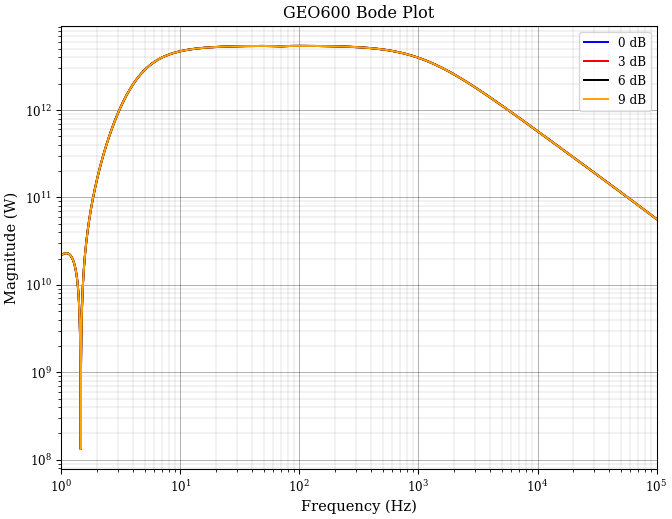

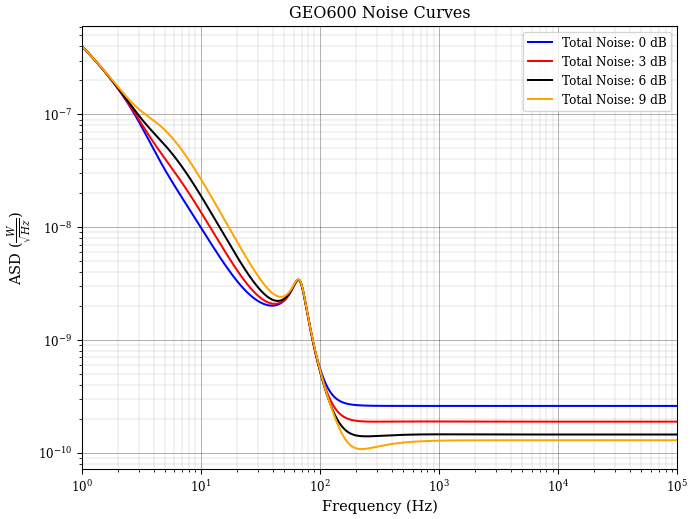

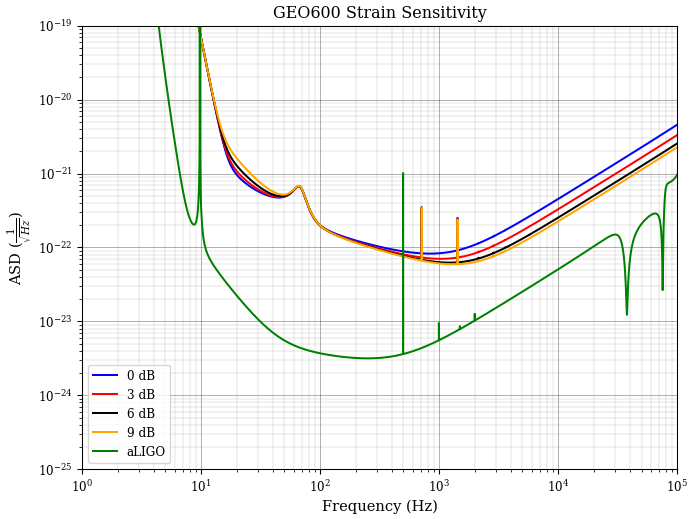

In [25]:
# Plot Transfer Functions, Noise Curves, and strain sensitivities
plot_tF(GEO_transfer_functions, label_list)
plot_nC(GEO_noise_curves, label_list)
plot_NSR(GEO_ASD_list, label_list)

# Create NPZ files of different interferometer configurations: 

In [36]:
# Uncomment the section needed to be completed

# Create and initialize a npz file:
# np.savez('ASD_50W_100000_05_new.npz', freqs=np.logspace(0,5,100000), GEO600=GEO_ASD_list[0])


# Add ASD arrays of different parameter configurations from the simulation to the npz file:

# with np.load('ASD_50W_100000_05_new.npz') as data:
#     existing_data = dict(data.items())
#     for i, ASD in enumerate(GEO_ASD_list):
#         # Append the new ASD array under a different key, e.g., 'ASD'
#         existing_data[f'GEO600_{srm_phi[i]}'] = ASD
        
#         # Save the updated data back to the .npz file
#         np.savez('ASD_50W_100000_05_new.npz', **existing_data)



# Add pygwinc sensitivity curve arrays of other interferometers:

# with np.load('ASD_50W_100000_05.npz') as data:
    
#     existing_data = dict(data.items())
    
#     temp_sensitivity_curve_name = ligo_NSR()
    
#     existing_data['CE'] = temp_sensitivity_curve_name

#     # Save the updated data back to the .npz file
#     np.savez('ASD_50W_100000_05.npz', **existing_data)


# Delete an array from a zip file:
'''
# Load the existing .npz file
with np.load('50W_100000_ASD05.npz') as data:
    # Convert the loaded data to a dictionary to modify it
    data_dict = dict(data.items())

# Remove the specific item (for example, removing 'ASD2')
if 'GEO600 Scanned' in data_dict:
    del data_dict['GEO600 Scanned']
    
# Save the remaining data back to the same .npz file
np.savez('50W_100000_ASD05.npz', **data_dict)
'''

# To view the array names in the file:
'''
with np.load('1000_ASD05.npz') as data:
    for name in data.files:
        print(name)
'''

"\nwith np.load('1000_ASD05.npz') as data:\n    for name in data.files:\n        print(name)\n"